# 추론 지연시간 실험
같은 환경 내 같은 데이터셋으로 각 모델 별 inference 수행 후 추론 지연시간 비교

## Set env

In [1]:
!nvidia-smi

Wed Sep 14 16:21:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   44C    P8    21W / 370W |     50MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
!pip3 install pillow
!pip3 install numpy==1.21
!pip3 install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 10.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 957.2/957.2 kB 10.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.9 MB/s eta 0:00:00a 0:00:01


## Test per model

### load model

In [3]:
import torch

## models lists
model_res18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model_res34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model_res50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model_res101 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
model_res152 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)

Using cache found in /home/keti/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/keti/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/keti/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/keti/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/keti/.cache/torch/hub/pytorch_vision_v0.10.0


### load Dataset

In [30]:
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms

# Image preprocessing modules
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

cifar10_test = dset.CIFAR10('./dataset', train=False, download=True,
                            transform=preprocess)
test_loader = DataLoader(cifar10_test, batch_size=128)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


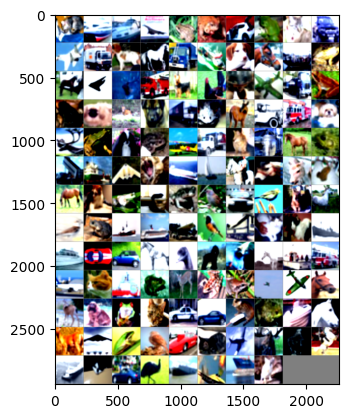

cat   ship  ship  plane


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(test_loader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images, 10))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [16]:
cifar10_test

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./dataset
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
torch.cuda.is_available()

True

In [7]:
!pip install tqdm

In [17]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2022-09-14 16:36:33--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
raw.githubusercontent.com (raw.githubusercontent.com) 해석 중... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
다음으로 연결 중: raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 10472 (10K) [text/plain]
저장 위치: `imagenet_classes.txt.2'

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    / 0.004s   

2022-09-14 16:36:34 (2.35 MB/s) - `imagenet_classes.txt.2' 저장함 [10472/10472]



In [19]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [43]:
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

# gpu set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Test the model
model = model_res152
if torch.cuda.is_available():
    model.to('cuda')

with torch.no_grad():
    start = time.time()
    correct = 0
    total = 0
    for data in tqdm(test_loader, mininterval=0.01):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct // total))
    print("소요시간 : ", time.time() - start)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:26<00:00,  2.93it/s]

Accuracy of the model on the test images: 0 %
소요시간 :  26.993821382522583
